In [ ]:
import os
import shutil
import itertools
import pathlib
from PIL import Image

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import plotly.express as px

%config InlineBackend.figure_format = 'svg'
plt.rcParams ['figure.figsize'] = (10,5)
sns.set(style='white', context='talk', font_scale=0.8)

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from sklearn.metrics import roc_curve, auc


from tqdm import tqdm  # Import tqdm for progress bar

import warnings
warnings.filterwarnings('ignore')
print('Using PyTorch version', torch.__version__)
# Setup device-agnostic code

Using PyTorch version 2.2.2


In [ ]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

device = get_device()

device

'cuda'

In [ ]:
metadata = pd.read_csv('ISIC/ISIC_2019_Training_Metadata.csv')
ground_truth = pd.read_csv('ISIC/ISIC_2019_Training_GroundTruth.csv')
# Concatenate the two DataFrames based on the 'image' column
df = pd.merge(ground_truth, metadata, on='image').drop('lesion_id', axis=1)
df['target'] = df[['MEL', 'NV', 'BCC', 'AK', 'DF', 'VASC', 'SCC', 'UNK']].sum(axis=1) # 1 for Malignant || 0 for Benign
diagnosis_map = {0: 'benign', 1: 'malignant'}
df['diagnosis'] = df['target'].map(diagnosis_map)
data = df.loc[:, ['image', 'age_approx', 'anatom_site_general', 'sex', 'target', 'diagnosis']]
data['image'] = 'ISIC/ISIC_2019_Training_Input/ISIC_2019_Training_Input/' + data['image'] + '.jpg'
# data['anatom_site_general'] = data['anatom_site_general'].replace(['lateral torso', 'anterior torso', 'posterior torso'], 'torso')
data

,image,age_approx,anatom_site_general,sex,target,diagnosis
0,ISIC/ISIC_2019_Training_Input/ISIC_2019_Traini...,55.0,anterior torso,female,1.0,malignant
1,ISIC/ISIC_2019_Training_Input/ISIC_2019_Traini...,30.0,anterior torso,female,1.0,malignant
2,ISIC/ISIC_2019_Training_Input/ISIC_2019_Traini...,60.0,upper extremity,female,1.0,malignant
3,ISIC/ISIC_2019_Training_Input/ISIC_2019_Traini...,30.0,upper extremity,male,1.0,malignant
4,ISIC/ISIC_2019_Training_Input/ISIC_2019_Traini...,80.0,posterior torso,male,1.0,malignant
...,...,...,...,...,...,...
25326,ISIC/ISIC_2019_Training_Input/ISIC_2019_Traini...,85.0,head/neck,female,1.0,malignant
25327,ISIC/ISIC_2019_Training_Input/ISIC_2019_Traini...,65.0,anterior torso,male,0.0,benign
25328,ISIC/ISIC_2019_Training_Input/ISIC_2019_Traini...,70.0,lower extremity,male,1.0,malignant
25329,ISIC/ISIC_2019_Training_Input/ISIC_2019_Traini...,55.0,palms/soles,female,1.0,malignant


In [ ]:
labelencoder= LabelEncoder()
data['anatom_site_general_encoded'] = labelencoder.fit_transform(data['anatom_site_general'])
data['sex_encoded'] = labelencoder.fit_transform(data['sex'])
data['diagnosis_encoded'] = labelencoder.fit_transform(data['diagnosis'])
data_NoC=data.drop(['anatom_site_general', 'sex', 'diagnosis'], axis=1)
# scale the age
scaler = MinMaxScaler()
data_NoC['age_approx'] = scaler.fit_transform(data_NoC['age_approx'].values.reshape(-1, 1))

data_NoC.head()

,image,age_approx,target,anatom_site_general_encoded,sex_encoded,diagnosis_encoded
0,ISIC/ISIC_2019_Training_Input/ISIC_2019_Traini...,0.647059,1.0,0,0,1
1,ISIC/ISIC_2019_Training_Input/ISIC_2019_Traini...,0.352941,1.0,0,0,1
2,ISIC/ISIC_2019_Training_Input/ISIC_2019_Traini...,0.705882,1.0,7,0,1
3,ISIC/ISIC_2019_Training_Input/ISIC_2019_Traini...,0.352941,1.0,7,1,1
4,ISIC/ISIC_2019_Training_Input/ISIC_2019_Traini...,0.941176,1.0,6,1,1


In [ ]:
data_NoC.shape

(25331, 6)

In [ ]:
train_data, test_data = train_test_split(data_NoC, test_size=0.3, stratify=data_NoC['target'], random_state=42)
valid_data, test_data = train_test_split(test_data, test_size=0.5, stratify=test_data['target'], random_state=42)

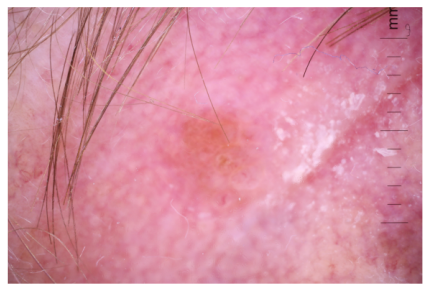

,image,age_approx,target,anatom_site_general_encoded,sex_encoded,diagnosis_encoded
6769,ISIC/ISIC_2019_Training_Input/ISIC_2019_Traini...,0.647059,1.0,3,0,1
24369,ISIC/ISIC_2019_Training_Input/ISIC_2019_Traini...,0.470588,1.0,0,1,1
19882,ISIC/ISIC_2019_Training_Input/ISIC_2019_Traini...,0.705882,1.0,0,0,1
20168,ISIC/ISIC_2019_Training_Input/ISIC_2019_Traini...,0.941176,1.0,7,1,1
5203,ISIC/ISIC_2019_Training_Input/ISIC_2019_Traini...,0.823529,0.0,6,0,0
...,...,...,...,...,...,...
18302,ISIC/ISIC_2019_Training_Input/ISIC_2019_Traini...,0.941176,1.0,1,1,1
13862,ISIC/ISIC_2019_Training_Input/ISIC_2019_Traini...,NaN,0.0,0,2,0
7269,ISIC/ISIC_2019_Training_Input/ISIC_2019_Traini...,0.588235,1.0,3,0,1
12690,ISIC/ISIC_2019_Training_Input/ISIC_2019_Traini...,0.941176,1.0,1,0,1


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Define the file path of the image you want to display
image_path = 'jpeg/train/ISIC_2637011.jpg'

# Open the image using PIL
image = Image.open(image_path)

# Display the image using matplotlib
plt.figure()
plt.imshow(image)
plt.axis('off')  # Turn off the axis
plt.show()

train_data

Data loading and preprocessing completed.


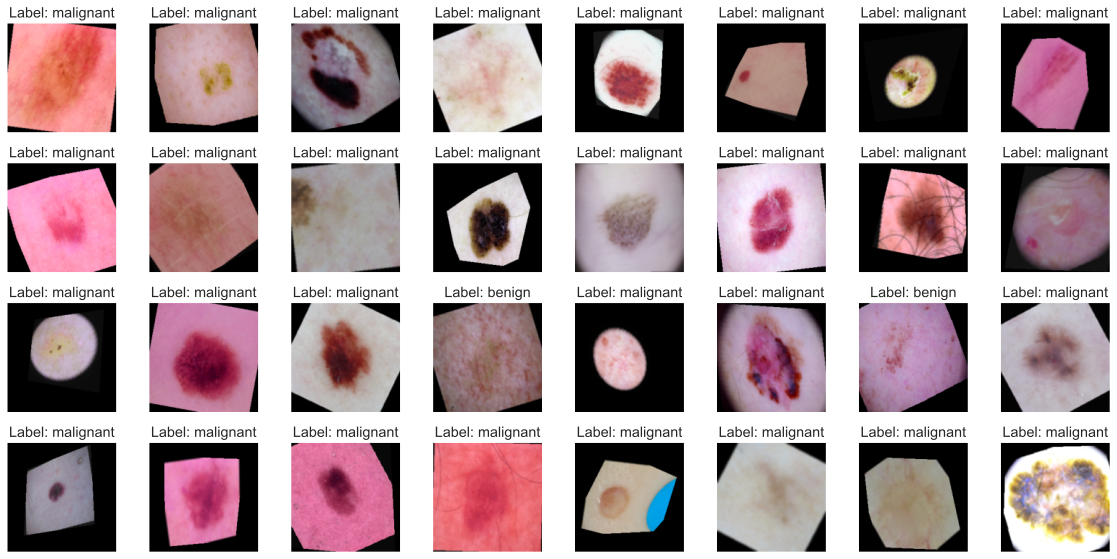

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        image = Image.open(img_name)

        age = torch.tensor(self.dataframe.iloc[idx, 1], dtype=torch.float32).to(device)
        anatom_site = torch.tensor(self.dataframe.iloc[idx, 3], dtype=torch.float32).to(device)
        sex = torch.tensor(self.dataframe.iloc[idx, 4], dtype=torch.float32).to(device)
        label = torch.tensor(self.dataframe.iloc[idx, 5], dtype=torch.long).to(device)

        if self.transform:
            image = self.transform(image)

        return image.to(device), age, anatom_site, sex, label


train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=7)], p=0.5),
    transforms.RandomApply([transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10)], p=0.5),
    transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.5)], p=0.5),
    transforms.ToTensor(),
])

# Define transforms for the data (adjust as necessary)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Define dataset and dataloaders for train and test sets
train_dataset = CustomDataset(train_data, transform=train_transform)

valid_dataset = CustomDataset(valid_data, transform=test_transform)
test_dataset = CustomDataset(test_data, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,drop_last=True)

valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)

print('Data loading and preprocessing completed.')


# Get one batch
for batch in train_loader:
    images, ages, anatom_sites, sexs, labels = batch
    break

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(16, 8))

# Flatten the axs array so that we can iterate over subplots easily
axs = axs.flatten()

# Plot each image
for i, ax in enumerate(axs):
    ax.imshow(images[i].permute(1, 2, 0).cpu().numpy())  # Convert tensor to numpy array and permute dimensions
    ax.axis('off')  # Turn off axis
    ax.set_title(f'Label: {diagnosis_map[int(labels[i])]}')  # Set title for each subplot

plt.tight_layout()  # Adjust layout to make subplots fit
plt.show()

<a id='5'></a>
<div style='background-color: #34495e; padding: 20px; border-radius: 10px; color: #ffffff; text-align: center;'>
    <h1 style='margin: 0; color: #ecf0f1;'>DenseNet-121</h1>
</div>


In [ ]:
DenseNet121 = torchvision.models.densenet121(pretrained=True).to(device)
print(DenseNet121)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
num_ftrs = DenseNet121.classifier.in_features
num_ftrs

1024

In [ ]:
DenseNet121.classifier = nn.Linear(in_features=num_ftrs, out_features=2).to(device)

In [ ]:
for batch in train_loader:
    images, ages, anatom_sites, sexs, labels = [item.to(device) for item in batch]
    break

In [ ]:
model = DenseNet121.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
import os

epochs = 50
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_accuracy = 0.0
best_model_path = 'best_DenseNet121.pth'

for epoch in range(epochs):
    # Training loop
    model.train()
    train_correct = 0
    train_total = 0
    train_running_loss = 0.0

    for data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} (Training)"):
        inputs, ages, anatom_sites, sexs, labels = [item.to(device) for item in data]

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_epoch_loss = train_running_loss / len(train_loader)
    train_epoch_accuracy = train_correct / train_total

    # Validation loop
    model.eval()  # Set model to evaluation mode
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0

    with torch.no_grad():  # Disable gradient computation during validation
        for data in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{epochs} (Validation)"):
            inputs, ages, anatom_sites, sexs, labels = [item.to(device) for item in data]

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(valid_loader)
    val_epoch_accuracy = val_correct / val_total

    # Store loss and accuracy values
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)

    # Save the best model based on validation accuracy
    if val_epoch_accuracy > best_val_accuracy:
        best_val_accuracy = val_epoch_accuracy
        torch.save(model.state_dict(), best_model_path)

    # Print training and validation information
    print(f"Epoch {epoch+1}/{epochs}, "
          f"Training Loss: {train_epoch_loss:.4f}, Training Accuracy: {train_epoch_accuracy:.2%}, "
          f"Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.2%}")

print("Training complete!")
print(f"Best validation accuracy: {best_val_accuracy:.2%}")

Epoch 1/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.87it/s]


Epoch 1/50, Training Loss: 0.3083, Training Accuracy: 89.33%, Validation Loss: 0.2636, Validation Accuracy: 90.16%


Epoch 2/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.88it/s]


Epoch 2/50, Training Loss: 0.2692, Training Accuracy: 90.00%, Validation Loss: 0.2519, Validation Accuracy: 91.03%


Epoch 3/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.88it/s]


Epoch 3/50, Training Loss: 0.2549, Training Accuracy: 90.37%, Validation Loss: 0.2285, Validation Accuracy: 91.68%


Epoch 4/50 (Validation): 100%|██████████| 119/119 [01:02<00:00,  1.89it/s]


Epoch 4/50, Training Loss: 0.2440, Training Accuracy: 90.53%, Validation Loss: 0.2193, Validation Accuracy: 91.55%


Epoch 5/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.89it/s]


Epoch 5/50, Training Loss: 0.2312, Training Accuracy: 91.00%, Validation Loss: 0.2121, Validation Accuracy: 92.00%


Epoch 6/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.88it/s]


Epoch 6/50, Training Loss: 0.2206, Training Accuracy: 91.38%, Validation Loss: 0.2117, Validation Accuracy: 91.97%


Epoch 7/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.87it/s]


Epoch 7/50, Training Loss: 0.2108, Training Accuracy: 91.85%, Validation Loss: 0.2022, Validation Accuracy: 91.97%


Epoch 8/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.87it/s]


Epoch 8/50, Training Loss: 0.2010, Training Accuracy: 92.22%, Validation Loss: 0.2011, Validation Accuracy: 92.50%


Epoch 9/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.88it/s]


Epoch 9/50, Training Loss: 0.1939, Training Accuracy: 92.31%, Validation Loss: 0.2031, Validation Accuracy: 92.50%


Epoch 10/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.87it/s]


Epoch 10/50, Training Loss: 0.1832, Training Accuracy: 92.75%, Validation Loss: 0.2148, Validation Accuracy: 91.16%


Epoch 11/50 (Validation): 100%|██████████| 119/119 [01:02<00:00,  1.90it/s]


Epoch 11/50, Training Loss: 0.1840, Training Accuracy: 92.68%, Validation Loss: 0.2083, Validation Accuracy: 92.50%


Epoch 12/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.89it/s]


Epoch 12/50, Training Loss: 0.1754, Training Accuracy: 93.15%, Validation Loss: 0.2306, Validation Accuracy: 90.92%


Epoch 13/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.88it/s]


Epoch 13/50, Training Loss: 0.1655, Training Accuracy: 93.28%, Validation Loss: 0.2159, Validation Accuracy: 92.37%


Epoch 14/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.88it/s]


Epoch 14/50, Training Loss: 0.1580, Training Accuracy: 93.68%, Validation Loss: 0.2062, Validation Accuracy: 91.87%


Epoch 15/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.88it/s]


Epoch 15/50, Training Loss: 0.1521, Training Accuracy: 93.86%, Validation Loss: 0.1999, Validation Accuracy: 92.45%


Epoch 16/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.89it/s]


Epoch 16/50, Training Loss: 0.1489, Training Accuracy: 94.02%, Validation Loss: 0.2099, Validation Accuracy: 92.84%


Epoch 17/50 (Validation): 100%|██████████| 119/119 [01:02<00:00,  1.89it/s]


Epoch 17/50, Training Loss: 0.1423, Training Accuracy: 94.24%, Validation Loss: 0.1998, Validation Accuracy: 92.84%


Epoch 18/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.88it/s]


Epoch 18/50, Training Loss: 0.1381, Training Accuracy: 94.51%, Validation Loss: 0.2282, Validation Accuracy: 91.16%


Epoch 19/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.88it/s]


Epoch 19/50, Training Loss: 0.1309, Training Accuracy: 94.73%, Validation Loss: 0.2171, Validation Accuracy: 91.58%


Epoch 20/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.88it/s]


Epoch 20/50, Training Loss: 0.1275, Training Accuracy: 95.02%, Validation Loss: 0.2225, Validation Accuracy: 91.71%


Epoch 21/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.87it/s]


Epoch 21/50, Training Loss: 0.1213, Training Accuracy: 95.08%, Validation Loss: 0.2165, Validation Accuracy: 91.89%


Epoch 22/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.87it/s]


Epoch 22/50, Training Loss: 0.1144, Training Accuracy: 95.32%, Validation Loss: 0.2093, Validation Accuracy: 92.89%


Epoch 23/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.88it/s]


Epoch 23/50, Training Loss: 0.1146, Training Accuracy: 95.42%, Validation Loss: 0.2279, Validation Accuracy: 93.29%


Epoch 24/50 (Validation): 100%|██████████| 119/119 [01:02<00:00,  1.89it/s]


Epoch 24/50, Training Loss: 0.1122, Training Accuracy: 95.70%, Validation Loss: 0.2222, Validation Accuracy: 93.21%


Epoch 25/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.88it/s]


Epoch 25/50, Training Loss: 0.1056, Training Accuracy: 95.88%, Validation Loss: 0.2298, Validation Accuracy: 92.26%


Epoch 26/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.87it/s]


Epoch 26/50, Training Loss: 0.0977, Training Accuracy: 96.29%, Validation Loss: 0.2087, Validation Accuracy: 92.92%


Epoch 27/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.87it/s]


Epoch 27/50, Training Loss: 0.0951, Training Accuracy: 96.27%, Validation Loss: 0.2271, Validation Accuracy: 93.26%


Epoch 28/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.88it/s]


Epoch 28/50, Training Loss: 0.0956, Training Accuracy: 96.29%, Validation Loss: 0.2343, Validation Accuracy: 92.50%


Epoch 29/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.87it/s]


Epoch 29/50, Training Loss: 0.0919, Training Accuracy: 96.43%, Validation Loss: 0.2196, Validation Accuracy: 93.13%


Epoch 30/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.88it/s]


Epoch 30/50, Training Loss: 0.0854, Training Accuracy: 96.75%, Validation Loss: 0.2057, Validation Accuracy: 94.08%


Epoch 31/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.88it/s]


Epoch 31/50, Training Loss: 0.0820, Training Accuracy: 96.78%, Validation Loss: 0.2063, Validation Accuracy: 94.00%


Epoch 32/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.88it/s]


Epoch 32/50, Training Loss: 0.0800, Training Accuracy: 97.06%, Validation Loss: 0.2539, Validation Accuracy: 94.00%


Epoch 33/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.89it/s]


Epoch 33/50, Training Loss: 0.0730, Training Accuracy: 97.17%, Validation Loss: 0.2348, Validation Accuracy: 94.16%


Epoch 34/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.89it/s]


Epoch 34/50, Training Loss: 0.0783, Training Accuracy: 97.02%, Validation Loss: 0.2319, Validation Accuracy: 92.87%


Epoch 35/50 (Validation): 100%|██████████| 119/119 [01:02<00:00,  1.89it/s]


Epoch 35/50, Training Loss: 0.0785, Training Accuracy: 96.93%, Validation Loss: 0.2472, Validation Accuracy: 93.21%


Epoch 36/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.87it/s]


Epoch 36/50, Training Loss: 0.0681, Training Accuracy: 97.51%, Validation Loss: 0.2625, Validation Accuracy: 91.79%


Epoch 37/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.88it/s]


Epoch 37/50, Training Loss: 0.0679, Training Accuracy: 97.35%, Validation Loss: 0.2305, Validation Accuracy: 94.24%


Epoch 38/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.88it/s]


Epoch 38/50, Training Loss: 0.0676, Training Accuracy: 97.44%, Validation Loss: 0.2072, Validation Accuracy: 94.26%


Epoch 39/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.87it/s]


Epoch 39/50, Training Loss: 0.0620, Training Accuracy: 97.63%, Validation Loss: 0.2204, Validation Accuracy: 94.58%


Epoch 40/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.87it/s]


Epoch 40/50, Training Loss: 0.0647, Training Accuracy: 97.51%, Validation Loss: 0.2248, Validation Accuracy: 94.26%


Epoch 41/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.86it/s]


Epoch 41/50, Training Loss: 0.0597, Training Accuracy: 97.79%, Validation Loss: 0.2288, Validation Accuracy: 94.21%


Epoch 42/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.88it/s]


Epoch 42/50, Training Loss: 0.0560, Training Accuracy: 98.00%, Validation Loss: 0.2336, Validation Accuracy: 93.13%


Epoch 43/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.87it/s]


Epoch 43/50, Training Loss: 0.0561, Training Accuracy: 97.92%, Validation Loss: 0.3047, Validation Accuracy: 91.47%


Epoch 44/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.87it/s]


Epoch 44/50, Training Loss: 0.0628, Training Accuracy: 97.63%, Validation Loss: 0.2216, Validation Accuracy: 94.24%


Epoch 45/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.88it/s]


Epoch 45/50, Training Loss: 0.0530, Training Accuracy: 98.01%, Validation Loss: 0.2245, Validation Accuracy: 93.50%


Epoch 46/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.87it/s]


Epoch 46/50, Training Loss: 0.0526, Training Accuracy: 98.03%, Validation Loss: 0.2432, Validation Accuracy: 93.53%


Epoch 47/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.86it/s]


Epoch 47/50, Training Loss: 0.0516, Training Accuracy: 98.03%, Validation Loss: 0.2473, Validation Accuracy: 93.87%


Epoch 48/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.87it/s]


Epoch 48/50, Training Loss: 0.0497, Training Accuracy: 98.05%, Validation Loss: 0.2587, Validation Accuracy: 94.24%


Epoch 49/50 (Validation): 100%|██████████| 119/119 [01:03<00:00,  1.88it/s]


Epoch 49/50, Training Loss: 0.0498, Training Accuracy: 98.09%, Validation Loss: 0.2462, Validation Accuracy: 93.39%


Epoch 50/50 (Validation): 100%|██████████| 119/119 [01:04<00:00,  1.86it/s]

Epoch 50/50, Training Loss: 0.0487, Training Accuracy: 98.30%, Validation Loss: 0.2580, Validation Accuracy: 93.08%
Training complete!
Best validation accuracy: 94.58%


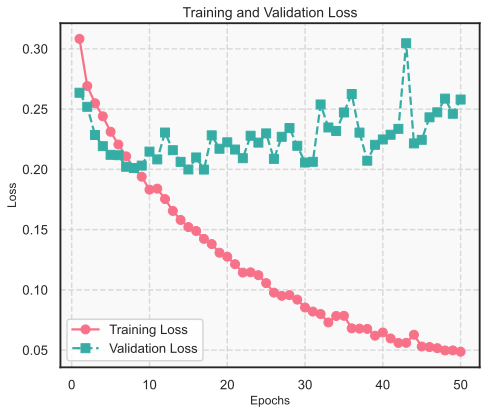

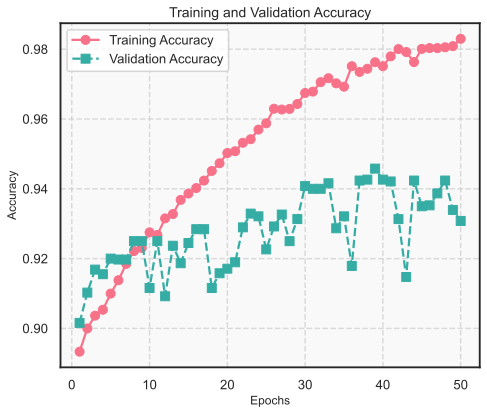

In [ ]:
# Set custom color palette
colors = sns.color_palette("husl", 2)

# Plotting training and validation loss
plt.figure(figsize=(7, 6))
plt.plot(range(1, epochs + 1), train_losses, marker='o', linestyle='-', color=colors[0], label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, marker='s', linestyle='--', color=colors[1], label='Validation Loss')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().set_facecolor('#f9f9f9')  # Set background color
plt.tight_layout()
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(7, 6))
plt.plot(range(1, epochs + 1), train_accuracies, marker='o', linestyle='-', color=colors[0], label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, marker='s', linestyle='--', color=colors[1], label='Validation Accuracy')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training and Validation Accuracy', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().set_facecolor('#f9f9f9')  # Set background color
plt.tight_layout()
plt.show()

In [ ]:
# Define paths and create directories if they don't exist
results_dir = 'results'
os.makedirs(results_dir, exist_ok=True)

# Initialize lists to store test results
test_losses = []
test_accuracies = []
test_precisions = []
test_recalls = []
test_f1_scores = []

# Set model to evaluation mode
model.eval()

# Initialize variables for test evaluation
test_correct = 0
test_total = 0
test_running_loss = 0.0
y_true = []
y_pred = []

# Evaluate on test set
with torch.no_grad():
    for data in tqdm(test_loader, desc="Testing"):
        inputs, ages, anatom_sites, sexs, labels = [item.to(device) for item in data]

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute test metrics
test_loss = test_running_loss / len(test_loader)
test_accuracy = test_correct / test_total
test_precision = precision_score(y_true, y_pred, average='weighted')
test_recall = recall_score(y_true, y_pred, average='weighted')
test_f1 = f1_score(y_true, y_pred, average='weighted')

# Print test results
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2%}")
print(f"Test Precision: {test_precision:.2f}, Test Recall: {test_recall:.2f}, Test F1 Score: {test_f1:.2f}")

# Save test results
test_results_file = os.path.join(results_dir, 'test_results.txt')
with open(test_results_file, 'w') as file:
    file.write(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2%}\n")
    file.write(f"Test Precision: {test_precision:.2f}, Test Recall: {test_recall:.2f}, Test F1 Score: {test_f1:.2f}\n")

Testing: 100%|██████████| 118/118 [01:04<00:00,  1.82it/s]

Test Loss: 0.2427, Test Accuracy: 93.46%
Test Precision: 0.94, Test Recall: 0.93, Test F1 Score: 0.94


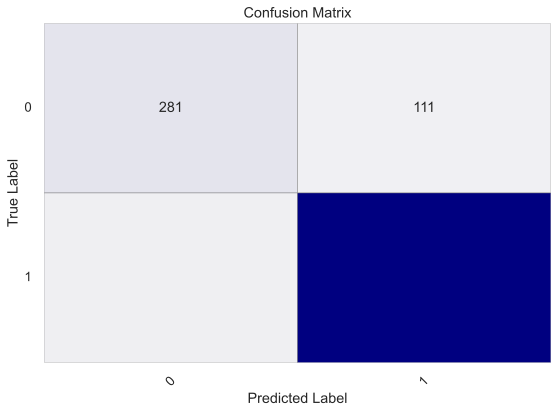

In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Define a color palette
color_palette = sns.light_palette("navy", as_cmap=True)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap=color_palette, fmt='d', cbar=False, linewidths=0.5, linecolor='gray')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Extract TP, TN, FP, FN from confusion matrix
TN, FP, FN, TP = conf_matrix.ravel()

# Calculate Sensitivity (Recall) and Specificity
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

# Print Sensitivity and Specificity
print(f"Sensitivity: {sensitivity:.2f}, Specificity: {specificity:.2f}")

Sensitivity: 0.96, Specificity: 0.72


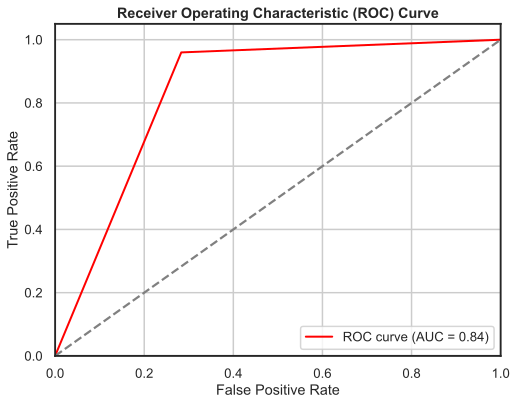

In [ ]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
roc_df = pd.DataFrame({'False Positive Rate': fpr, 'True Positive Rate': tpr})

In [ ]:
roc_df

,False Positive Rate,True Positive Rate
0,0.000000,0.000000
1,0.283163,0.959811
2,1.000000,1.000000


In [ ]:
roc_file_path = 'densenet121_roc_curve.csv'

# Save the DataFrame to a CSV file
roc_df.to_csv(roc_file_path, index=False)

print("ROC curve data saved successfully.")

ROC curve data saved successfully.
